![Python Logo](../../assets/images/python-logo-master-v3-TM.png)

# <center> Applying Word2Vec on AskUbuntu Question Data </center>
### <center> Shagun Sodhani </center>

In [1]:
# put in the name of the Stack Exchange Site which you want to analyse.
data_source = "AskUbuntu"
data_type = "Question"
local_question_data_path = "../../data/"+data_source+"/"+data_type
use_local_datapath = True
# If this is set to false, dbfs_data_path is used to read the data.
dbfs_question_data_path = ""
# dbfs_data_path is to be used when running the notebook on Databricks and data has been uploaded to dbfs. 
# For more details, refer https://github.com/shagunsodhani/PyCon2016

## Let us begin

### We will import everything in one cell for the sake for reference.

In [2]:
import pyspark.sql.functions as func
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.mllib.feature import Word2Vec
from pyspark.mllib.feature import Word2VecModel
from pyspark.ml.feature import PCA
from time import time
import operator
%matplotlib inline
from __future__ import print_function

### Now let us load the question data as a dataframe. Since we will be using this data many times, we will cache it in memory.

In [3]:
start_time = time()
print ("data_source =", data_source)
print ("data_type =", data_type)
if(use_local_datapath):
    question_data_path = local_question_data_path
else:
    question_data_path = dbfs_question_data_path
print ("question_data_path =",question_data_path)
question_df = sqlContext.read.load(question_data_path).cache()
print ("Time taken =", time() - start_time, "seconds.")

data_source = AskUbuntu
data_type = Question
question_data_path = ../../data/AskUbuntu/Question
Time taken = 13.6627190113 seconds.


In [4]:
print("Schema for question dataframe")
question_df.printSchema()

Schema for question dataframe
root
 |-- Id: long (nullable = true)
 |-- AcceptedAnswerId: long (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- Score: long (nullable = true)
 |-- ViewCount: long (nullable = true)
 |-- Body: string (nullable = true)
 |-- OwnerUserId: long (nullable = true)
 |-- LastEditorUserId: long (nullable = true)
 |-- LastEditorDisplayName: string (nullable = true)
 |-- LastEditDate: string (nullable = true)
 |-- LastActivityDate: string (nullable = true)
 |-- CommunityOwnedDate: string (nullable = true)
 |-- ClosedDate: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- AnswerCount: long (nullable = true)
 |-- CommentCount: long (nullable = true)
 |-- FavoriteCount: long (nullable = true)



### We want to play with the question text data.

In [5]:
question_df.select('Body').show(5)

+--------------------+
|                Body|
+--------------------+
|<p>Update Manager...|
|<p>I take photos ...|
|<p>I have been pl...|
|<p>When you insta...|
|<p>I would like U...|
+--------------------+
only showing top 5 rows



In [6]:
question_df.select('Body').head()[0]

u'<p>Update Manager is constantly offering me updates (e.g. security fixes, updates from PPAs).</p>\n\n<p>How can I tell my Ubuntu installation to automatically download and install updates whenever they become available?</p>\n'

In [7]:
print ("Number of questions =", question_df.count())

Number of questions = 230177


### We need to clean up this data. Specifically, we want to remove the all the HTML tags. We will use the [regex_replace](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.functions.regexp_replace) function.

In [8]:
regex_to_remove = '<[^>]*>'
body_df = question_df.select(func.regexp_replace\
                   (func.regexp_replace('Body', '\n', ' '), regex_to_remove, '').alias('Body'))
body_df.head()[0]

u'Update Manager is constantly offering me updates (e.g. security fixes, updates from PPAs).  How can I tell my Ubuntu installation to automatically download and install updates whenever they become available? '

### Now we will replace each row with an array of words before we feed it to the Word2Vec Model. For this, we would use the [split function](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.functions.split) 

In [9]:
body_df.select(func.split('Body', ' ').alias('Body')).head()[0]

[u'Update',
 u'Manager',
 u'is',
 u'constantly',
 u'offering',
 u'me',
 u'updates',
 u'(e.g.',
 u'security',
 u'fixes,',
 u'updates',
 u'from',
 u'PPAs).',
 u'',
 u'How',
 u'can',
 u'I',
 u'tell',
 u'my',
 u'Ubuntu',
 u'installation',
 u'to',
 u'automatically',
 u'download',
 u'and',
 u'install',
 u'updates',
 u'whenever',
 u'they',
 u'become',
 u'available?',
 u'']

### We have many empty words, words in different cases and unnecessary punctuation marks in data. Lets update the regex to take care of these issues.


In [10]:
regex_to_remove = '<[^>]*>|\\\'|"|\(|\)|\[|\]'
body_df = question_df.select(func.lower(func.regexp_replace\
                   (func.regexp_replace('Body', '\n', ' '), regex_to_remove, '')).alias('Body'))
body_df = body_df.select(func.split('Body', ' ').alias('Body'))
print ("Number of words =", len(body_df.head()[0]))
body_df.head()[0]

Number of words = 32


[u'update',
 u'manager',
 u'is',
 u'constantly',
 u'offering',
 u'me',
 u'updates',
 u'e.g.',
 u'security',
 u'fixes,',
 u'updates',
 u'from',
 u'ppas.',
 u'',
 u'how',
 u'can',
 u'i',
 u'tell',
 u'my',
 u'ubuntu',
 u'installation',
 u'to',
 u'automatically',
 u'download',
 u'and',
 u'install',
 u'updates',
 u'whenever',
 u'they',
 u'become',
 u'available?',
 u'']

### We will remove the empty words using a udf (user defined function)

In [11]:
from pyspark.sql.types import ArrayType, StringType
remove_empty = func.udf(lambda row: filter(None, row), ArrayType(StringType()))
body_df = body_df.select(remove_empty('Body').alias('Body'))
print ("Number of words =", len(body_df.head()[0]))
body_df.head()[0]

Number of words = 30


[u'update',
 u'manager',
 u'is',
 u'constantly',
 u'offering',
 u'me',
 u'updates',
 u'e.g.',
 u'security',
 u'fixes,',
 u'updates',
 u'from',
 u'ppas.',
 u'how',
 u'can',
 u'i',
 u'tell',
 u'my',
 u'ubuntu',
 u'installation',
 u'to',
 u'automatically',
 u'download',
 u'and',
 u'install',
 u'updates',
 u'whenever',
 u'they',
 u'become',
 u'available?']

### Now that our data has been preprocessed, we can setup our model.


In [12]:
start_time = time()
word2vec = Word2Vec().setSeed(42)
body_data = body_df.map(lambda row: row[0])
model = word2vec.fit(body_data)
print ("Time taken =", time() - start_time, "seconds.")

Time taken = 861.547697067 seconds.


### We would save our model on disk so that we do not have to train it again.


In [13]:
path_to_save_model = "model/AskUbuntu/Question/Word2Vec"

In [14]:
start_time = time()
model.save(sc, path_to_save_model)
print ("Time taken =", time() - start_time, "seconds.")

Time taken = 8.57631611824 seconds.


### Now we see how to load the model from disk to main memory.


In [15]:
start_time = time()
loaded_model = Word2VecModel.load(sc, path_to_save_model)
word_to_test = "ubuntu"
loaded_model.transform(word_to_test) == model.transform(word_to_test)
print ("Time taken =", time() - start_time, "seconds.")

Time taken = 11.1817331314 seconds.


### Lets play with it now.


In [16]:
model.findSynonyms("14.04", 5)
word = "14.04"
synonyms = model.findSynonyms(word, 5)

for word, similarity in synonyms:
    print("{}: {}".format(word, similarity))
print (model)

12.04: 2.16638866271
16.04: 2.11491750414
14.10: 2.08178775852
15.04: 2.07868309706
14.04.2: 2.07382551201


In [17]:
word = "bash"
synonyms = model.findSynonyms(word, 5)

for word, similarity in synonyms:
    print("{}: {}".format(word, similarity))

script,: 1.59725651565
script.: 1.58845261155
test.sh: 1.5675463184
#!/bin/bash: 1.51736792887
script?: 1.50901785404


In [18]:
word = "trusty"
synonyms = model.findSynonyms(word, 5)

for word, similarity in synonyms:
    print("{}: {}".format(word, similarity))

precise: 3.24744999567
utopic: 3.22089182519
trusty-backports: 3.10068308008
saucy: 3.07197714872
http://ppa.launchpad.net/webupd8team/sublime-text-3/ubuntu: 3.06311970677


In [19]:
word1 = "14.04"
word2 = "trusty"
word3 = "12.04"
word4 = model.findSynonyms(model.transform(word1) + model.transform(word2) - model.transform(word3), 1)[0][0]
print (word4)

utopic


### 14.04 + trusty - 12.04 = precise

### We will now visualise all the tags using Word2Vec

### We will first get a list of all the tags

In [20]:
tags_df = question_df.select(func.regexp_replace\
                   (func.regexp_replace('Tags', '><', ','), '<|>', '').alias('Tags'))
tags_df.show(10, truncate = False)

+------------------------------------+
|Tags                                |
+------------------------------------+
|updates,unattended-upgrades         |
|wallpaper,artwork,photography       |
|package-management,uninstall        |
|command-line,package-management     |
|ntp                                 |
|applet,panel,networking             |
|metacity,window-buttons             |
|wine,browser,ie                     |
|thunderbird,google-calendar,calendar|
|firewall                            |
+------------------------------------+
only showing top 10 rows



In [21]:
tag_df = tags_df.select(func.explode(func.split('Tags', ',')).alias('Tag'))
tag_df.show(10, truncate = False)

+-------------------+
|Tag                |
+-------------------+
|updates            |
|unattended-upgrades|
|wallpaper          |
|artwork            |
|photography        |
|package-management |
|uninstall          |
|command-line       |
|package-management |
|ntp                |
+-------------------+
only showing top 10 rows



In [22]:
tag_df = tag_df.distinct()
print ("Number of distinct tags =", tag_df.count())

Number of distinct tags = 3012


### Now we will map the tags with their word2Vec vectors using the trained model.

### We will use a small utility function to filter tags that are not seen by our model (to be on the safe side).

In [23]:
def tag_in_model(tag):
    try:
        model.transform(tag)
        return True
    except Exception as e:
        return False

In [24]:
tag_list = tag_df.distinct().map(lambda tag: tag[0]).collect()
tag_vector_list = filter(tag_in_model, tag_list)
print ("Total number of tags =",len(tag_list))
print ("Number of tags after filtering =",len(tag_vector_list))

Total number of tags = 3012
Number of tags after filtering = 2423


In [25]:
tag_vector_map = [(tag, model.transform(tag)) for tag in tag_vector_list]
tag_vector_map[0]

(u'launchpad',
 DenseVector([0.079, 0.1939, 0.1229, 0.0771, -0.0332, -0.2031, 0.1031, -0.2131, 0.0186, 0.0321, 0.3534, 0.0147, 0.0674, -0.0782, 0.0269, -0.2566, -0.0583, -0.2015, 0.3284, -0.0177, 0.2227, -0.0507, -0.0519, -0.0208, -0.1326, 0.017, 0.0939, 0.0059, 0.072, 0.0568, -0.0849, -0.3906, 0.1042, -0.1886, 0.1587, 0.3733, 0.2201, -0.253, 0.6294, 0.1747, 0.439, 0.024, -0.0621, 0.2597, -0.2157, -0.3843, 0.1761, 0.2847, 0.007, 0.0727, 0.5245, 0.174, 0.2433, -0.2612, 0.1461, 0.1763, -0.4042, -0.0032, -0.1984, 0.0648, -0.0462, 0.0371, 0.2103, -0.1557, 0.1028, -0.2634, 0.3768, 0.3779, -0.3792, -0.0002, -0.0023, 0.3495, 0.0013, -0.1416, -0.1145, -0.0856, -0.228, -0.0189, 0.36, 0.0896, 0.0139, -0.3468, 0.0471, 0.0141, -0.1207, 0.2516, 0.1658, 0.0877, 0.2914, 0.0556, 0.4962, 0.0292, 0.2409, -0.0271, -0.1366, 0.1542, 0.2931, -0.0209, -0.031, -0.058]))

### So far, we have been reading RDDs and DataFrames. Now, we will make a RDD and a DataFrame from a list.

In [26]:
tag_vector_rdd = sc.parallelize(tag_vector_map, 9)
tag_vector_rdd.take(1)

[(u'launchpad',
  DenseVector([0.079, 0.1939, 0.1229, 0.0771, -0.0332, -0.2031, 0.1031, -0.2131, 0.0186, 0.0321, 0.3534, 0.0147, 0.0674, -0.0782, 0.0269, -0.2566, -0.0583, -0.2015, 0.3284, -0.0177, 0.2227, -0.0507, -0.0519, -0.0208, -0.1326, 0.017, 0.0939, 0.0059, 0.072, 0.0568, -0.0849, -0.3906, 0.1042, -0.1886, 0.1587, 0.3733, 0.2201, -0.253, 0.6294, 0.1747, 0.439, 0.024, -0.0621, 0.2597, -0.2157, -0.3843, 0.1761, 0.2847, 0.007, 0.0727, 0.5245, 0.174, 0.2433, -0.2612, 0.1461, 0.1763, -0.4042, -0.0032, -0.1984, 0.0648, -0.0462, 0.0371, 0.2103, -0.1557, 0.1028, -0.2634, 0.3768, 0.3779, -0.3792, -0.0002, -0.0023, 0.3495, 0.0013, -0.1416, -0.1145, -0.0856, -0.228, -0.0189, 0.36, 0.0896, 0.0139, -0.3468, 0.0471, 0.0141, -0.1207, 0.2516, 0.1658, 0.0877, 0.2914, 0.0556, 0.4962, 0.0292, 0.2409, -0.0271, -0.1366, 0.1542, 0.2931, -0.0209, -0.031, -0.058]))]

In [27]:
tag_vector_df = tag_vector_rdd.toDF(['Tag', 'Vector'])
tag_vector_df.show(2)

+---------+--------------------+
|      Tag|              Vector|
+---------+--------------------+
|launchpad|[0.07898210734128...|
| rabbitmq|[0.09427218884229...|
+---------+--------------------+
only showing top 2 rows



### Finally, we find the top 100 tags by order of occurence and visualise their pca_features.

In [48]:
start_time = time()
tag_df = tags_df.select(func.explode(func.split('Tags', ',')).alias('Tag')).cache()
position_data = tag_df.groupBy('Tag').count().join(tag_pca_df, tag_df['Tag'] == tag_pca_df['Tag'])\
.orderBy(func.desc('count')).select(tag_df['Tag'], 'pca_features')\
.map(lambda row: (row[0], row[1][0], row[1][1])).take(100)
print ("Number of tags =",len(position_data))
print ("Time taken =", time() - start_time, "seconds.")

Number of tags = 100
Time taken = 15.0586891174 seconds.


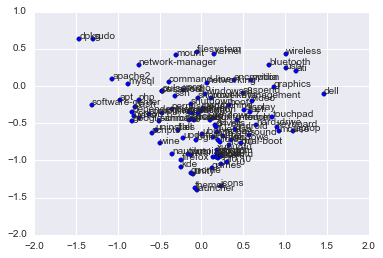

In [50]:
name_list, xs, ys = zip(*position_data)
%matplotlib qt
fig, ax = plt.subplots()
ax.scatter(xs, ys, marker = 'o')
for i, txt in enumerate(name_list):
    ax.annotate(txt, (xs[i],ys[i]))
plt.show()

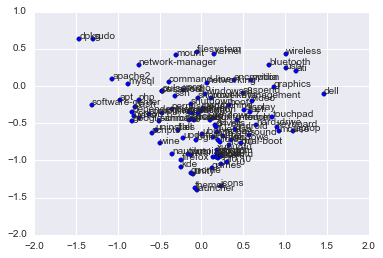

In [51]:
name_list, xs, ys = zip(*position_data)
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(xs, ys, marker = 'o')
for i, txt in enumerate(name_list):
    ax.annotate(txt, (xs[i],ys[i]))
plt.show()